# Visualize AI related bots/user agents from collected `robots.txt`

## 1. Import and config

In [1]:
import os
import time
import re

import numpy as np
import pandas as pd

if 'notebooks' in os.getcwd():
    os.chdir('..')

In [2]:
from matplotlib import (
    pyplot as plt, 
    dates as mdates,
    rcParams
)
import seaborn as sns
import sklearn

rcParams['font.family'] = 'Overpass Nerd Font'
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 18
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 1.5
rcParams['lines.markersize'] = 20
rcParams['patch.linewidth'] = 1.5
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.width'] = 2
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = False
rcParams['savefig.facecolor'] = 'white'
rcParams['savefig.format'] = 'svg'
rcParams['savefig.pad_inches'] = 0.5
rcParams['savefig.bbox'] = 'tight'

In [3]:
mbfc_cat_order = [
    'left',
    'leftcenter',
    'center',
    'right-center', 
    'right',
    'fake-news', 
    'conspiracy',
    'pro-science',
    'satire',
    'center | leftcenter',
    'center | right-center', 
    'fake-news | leftcenter'
]

## 2. Visualize sites from `mediabiasfactcheck`

In [4]:
df = pd.read_csv('data/proc/mbfc_sites_user_agents.csv')

In [5]:
df

site       user_agent mbfc_category  has_user_agents  \
0              euvsdisinfo.eu                *    leftcenter             True   
1      goderichsignalstar.com                *  right-center             True   
2      goderichsignalstar.com   googlebot-news  right-center             True   
3      goderichsignalstar.com        omgilibot  right-center             True   
4      goderichsignalstar.com           omgili  right-center             True   
...                       ...              ...           ...              ...   
19994             polygon.com   googlebot-news    leftcenter             True   
19995             polygon.com           gptbot    leftcenter             True   
19996             polygon.com  google-extended    leftcenter             True   
19997             polygon.com                *    leftcenter             True   
19998                24ur.com                *        center             True   

                   bot_tag  
0                      NaN  
1                      NaN  
2                      NaN  
3      possible-ai-crawler  
4      possible-ai-crawler  
...                    ...  
19994                  NaN  
19995  possible-ai-crawler  
19996  possible-ai-crawler  
19997                  NaN  
19998                  NaN  

[19999 rows x 5 columns]

In [6]:
df.drop_duplicates(['site', 'has_user_agents']).value_counts('has_user_agents')

has_user_agents
True     4488
False      20
dtype: int64

In [7]:
sites_with_taggedbots = (
    df.dropna(subset='bot_tag')
    [['site']]
    .reset_index(drop=True)
    .assign(site_has_tagged_bots=True)
)

df = (
    df.merge(sites_with_taggedbots, how='left')
    .fillna({'site_has_tagged_bots': False})
)

In [8]:
df

site       user_agent mbfc_category  has_user_agents  \
0              euvsdisinfo.eu                *    leftcenter             True   
1      goderichsignalstar.com                *  right-center             True   
2      goderichsignalstar.com                *  right-center             True   
3      goderichsignalstar.com   googlebot-news  right-center             True   
4      goderichsignalstar.com   googlebot-news  right-center             True   
...                       ...              ...           ...              ...   
39279             polygon.com  google-extended    leftcenter             True   
39280             polygon.com  google-extended    leftcenter             True   
39281             polygon.com                *    leftcenter             True   
39282             polygon.com                *    leftcenter             True   
39283                24ur.com                *        center             True   

                   bot_tag  site_has_tagged_bots  
0                      NaN                 False  
1                      NaN                  True  
2                      NaN                  True  
3                      NaN                  True  
4                      NaN                  True  
...                    ...                   ...  
39279  possible-ai-crawler                  True  
39280  possible-ai-crawler                  True  
39281                  NaN                  True  
39282                  NaN                  True  
39283                  NaN                 False  

[39284 rows x 6 columns]

In [9]:
df_site_summary = (
    df
    .drop_duplicates(['site', 'mbfc_category', 'site_has_tagged_bots'])
    .value_counts(
        ['mbfc_category', 'site_has_tagged_bots'],
    )
    .to_frame('num_sites')
    .reset_index()
    .sort_values(by='num_sites')
    .replace({
        'site_has_tagged_bots': {
            True: 'with AI bots',
            False: 'without AI bots'
        }
    })
    .pivot(
        index='mbfc_category',
        columns='site_has_tagged_bots',
        values='num_sites'
    )
    .fillna(0)
)

### 2.1. Bar plot of sites w/ vs. w/o AI-related bots, by `mbfc` category

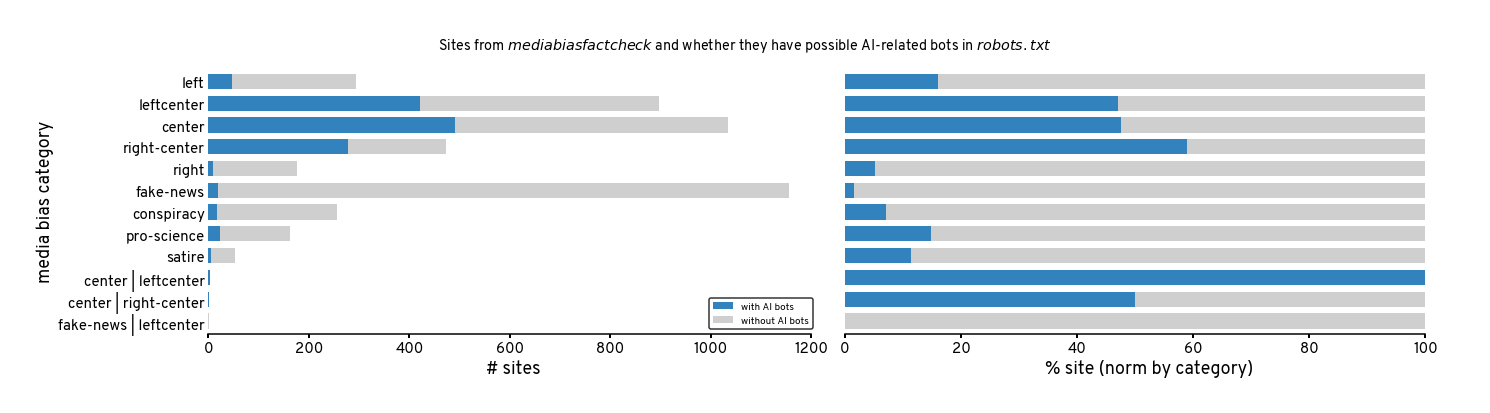

In [10]:
plt.figure(figsize=(20,5))

common_bar_kws = dict(
    kind='barh',
    stacked=True,
    color=['#3182bd', '#cfcfcf'],
    width=0.7,
)

ax1 = plt.subplot(121)
(
    df_site_summary
    .loc[mbfc_cat_order[::-1]]
    .plot(**common_bar_kws,ax=ax1)
)
ax1.set_xlabel('# sites')
ax1.set_ylabel('media bias category')
ax1.tick_params(axis='y', length=0)
ax1.legend(edgecolor='k', loc='lower right')

ax2 = plt.subplot(122)

(
    (df_site_summary * 100)
    .div(df_site_summary.sum(axis=1), axis=0)
    .loc[mbfc_cat_order[::-1]]
    .plot(**common_bar_kws,ax=ax2, legend=False)
)
ax2.set_yticks([])
ax2.set_ylabel(None)
ax2.set_xlabel('% site (norm by category)')

sns.despine(trim=True, left=True)
plt.suptitle('Sites from $mediabiasfactcheck$ and whether they have possible AI-related bots in $robots.txt$', fontsize='x-large')
plt.tight_layout()

plt.savefig('figures/mbfc-sites/category-barplot.svg')
plt.savefig('figures/mbfc-sites/category-barplot.png')

### 2.2. Bar plot of # AI related bots

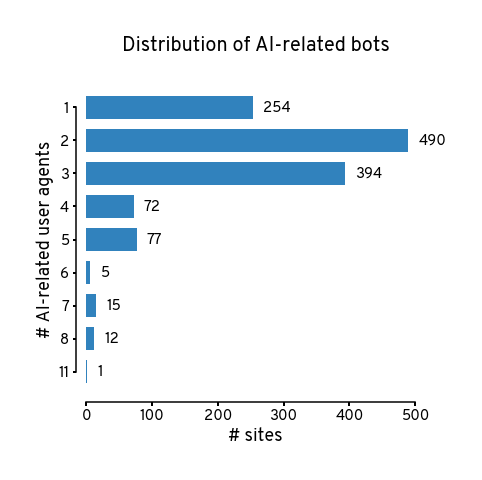

In [11]:
ax = (
    df
    .dropna(subset='bot_tag')
    .groupby('site')
    ['user_agent']
    .agg(lambda x: len(set(x)))
    .to_frame('num_agents')
    .reset_index()
    .value_counts('num_agents', sort=False)
    .plot(
        kind='barh',
        color = '#3182bd',
        width=0.7,
        figsize=(6,6)
    )
)

plt.bar_label(ax.containers[0], padding=10, fontsize=15)
plt.tick_params(rotation=0)
plt.xlabel('# sites')
plt.ylabel('# AI-related user agents')
plt.title('Distribution of AI-related bots', y=1.1)
plt.gca().invert_yaxis()
sns.despine(trim=True, offset=10)

plt.tight_layout()


plt.savefig('figures/mbfc-sites/num-aibot-barplot.svg')
plt.savefig('figures/mbfc-sites/num-aibot-barplot.png')

### 2.3. Most frequent bot combos

In [12]:
most_frequent_combos = (
    df
    .dropna(subset='bot_tag')
    .groupby('site')
    ['user_agent']
    .agg(
        combined_agent = lambda x: tuple(sorted(list(set(x)))),
        num_agents = lambda x: len(set(x))
    )
    .value_counts()
    .to_frame('count')
    .reset_index()
    .groupby('num_agents')
    .head(1)
    .sort_values('num_agents')
    .reset_index(drop=True)
)

all_bots_in_mfc = sorted(list(set(
    most_frequent_combos['combined_agent'].explode()
)))

most_frequent_combos

combined_agent  num_agents  count
0                                          (gptbot,)           1    228
1                                    (ccbot, gptbot)           2    269
2                      (ccbot, chatgpt-user, gptbot)           3    372
3     (ccbot, chatgpt-user, google-extended, gptbot)           4     51
4  (ccbot, chatgpt-user, google-extended, gptbot,...           5     41
5  (ccbot, google-extended, gptbot, omgili, omgil...           6      2
6  (anthropic-ai, ccbot, chatgpt-user, cohere-ai,...           7      9
7  (amazonbot, ccbot, facebookbot, google-extende...           8     11
8  (anthropic-ai, ccbot, chatgpt, chatgpt-user, c...          11      1

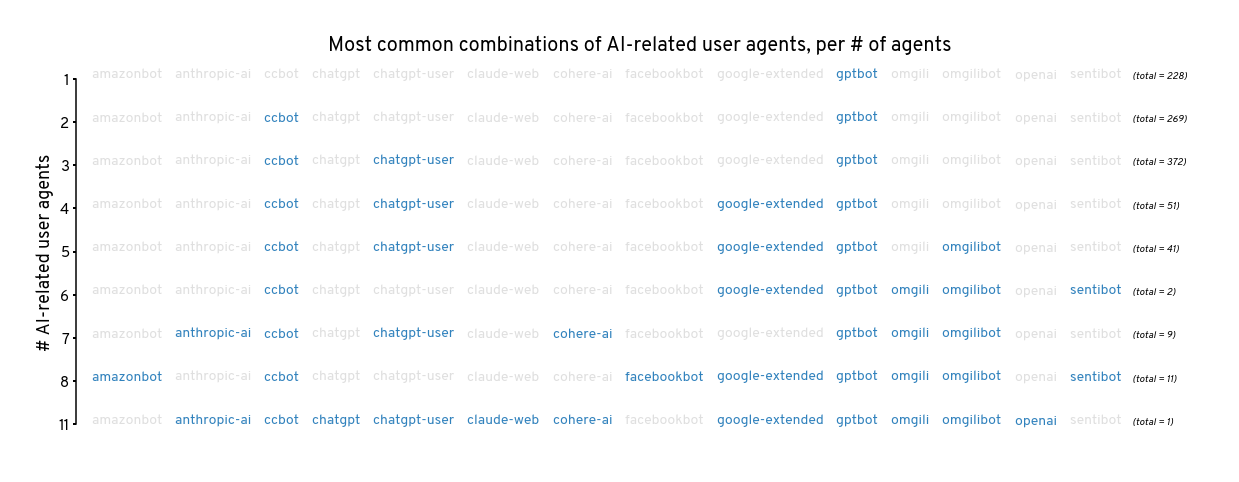

In [13]:
ax = plt.figure(figsize=(18,6)).add_subplot(xticks=[])

num_rows = len(most_frequent_combos)
ytick_vals = (np.arange(num_rows)+0.5)/num_rows
for i, row in most_frequent_combos.iterrows():
    text_obj = ax.text(0, ytick_vals[i], ' ', color="red")
    
    for b in all_bots_in_mfc:
        b_color = '#3182bd' if b in row['combined_agent'] else '#dfdfdf'
        text_obj = ax.annotate(
            text='    ' + b,
            color=b_color,
            xycoords=text_obj,
            xy=(1, 0),
            verticalalignment="bottom",
            fontweight='medium',
            fontsize=14
        )
        
    text = ax.annotate(
        text='     (total = %d)' %(row['count']),
        xycoords=text_obj,
        fontstyle='italic',
        xy=(1, 0),        
        verticalalignment="bottom"
    )

plt.yticks(ytick_vals, labels=most_frequent_combos['num_agents'])
plt.ylabel('# AI-related user agents')
plt.title('Most common combinations of AI-related user agents, per # of agents')
sns.despine(bottom=True, trim=True)
plt.gca().invert_yaxis()
plt.tight_layout()


plt.savefig('figures/mbfc-sites/aibot-mostfreqcombos.svg')
plt.savefig('figures/mbfc-sites/aibot-mostfreqcombos.png')

### 2.4. Matrix of bot vs `mbfc` category

In [14]:
bot_and_cat = (
    df
    .dropna(subset='bot_tag')
    .value_counts(['mbfc_category', 'user_agent'])
    .to_frame('num_sites')
    .reset_index()
    .pivot(
        index='user_agent',
        columns='mbfc_category',
        values='num_sites'
    )
    .fillna(0)
    .astype('int')
)


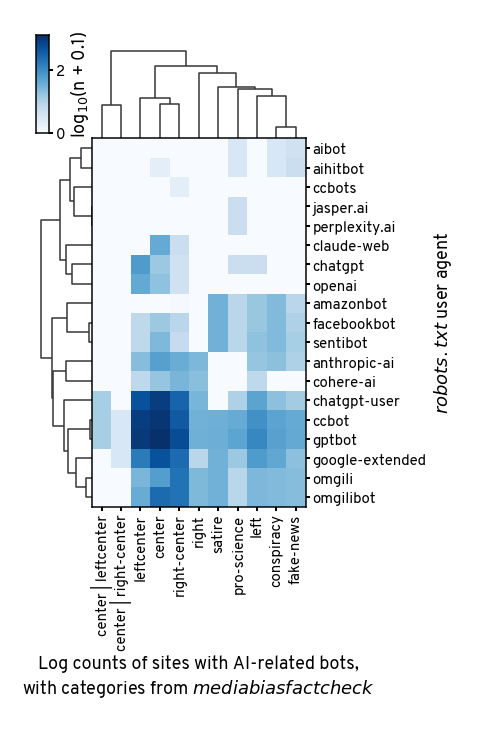

In [15]:
g = sns.clustermap(
    np.log10(bot_and_cat+0.1),
    z_score=None,
    cmap = 'Blues',
    vmin = 0,
    cbar_pos=(0.02, 0.85, 0.03, 0.15),
    figsize=(6,9),
    tree_kws={'linewidth':1.5},
)
g.cax.set_ylabel('log$_{10}$(n + 0.1)')
sns.despine(ax=g.ax_heatmap, left=False, right=False, top=False, bottom=False)
sns.despine(ax=g.ax_cbar, left=False, right=False, top=False, bottom=False)

g.ax_heatmap.set_ylabel(
    '$robots.txt$ user agent',
)

g.ax_heatmap.set_xlabel(
    'Log counts of sites with AI-related bots,\n'
    'with categories from $mediabiasfactcheck$',
    fontsize=18,
)



plt.savefig('figures/mbfc-sites/aibot-vs-cat-matrix.svg')
plt.savefig('figures/mbfc-sites/aibot-vs-cat-matrix.png')

### 2.5. Matrix of bots vs sites

In [16]:
bot_and_site = (
    df
    .dropna(subset='bot_tag')
    [['site', 'user_agent']]
    .drop_duplicates()
    .assign(count=1)
    .pivot(
        index='user_agent',
        columns='site',
        values='count'
    )
    .fillna(0)
)

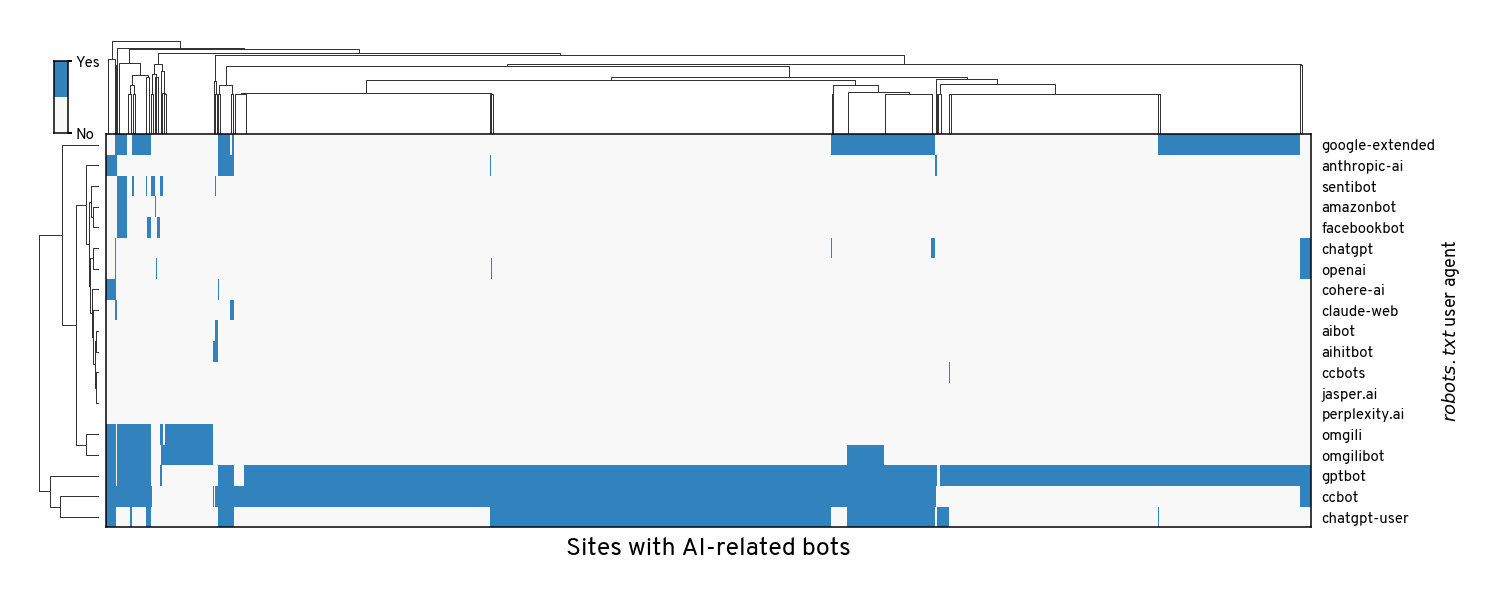

In [17]:
g = sns.clustermap(
    bot_and_site,
    cmap=['#f8f8f8', '#3182bd'],
    figsize=(20,10),
    vmin = 0,
    cbar_pos=(0.02, 0.85, 0.01, 0.1),
    tree_kws={'linewidth':1},
    dendrogram_ratio=(0.05,0.2),
)

g.ax_heatmap.set_xticks([])
g.ax_heatmap.tick_params(axis='y', length=0, pad=10)
g.ax_cbar.set_yticks([0,1], labels=['No', 'Yes'])

g.ax_heatmap.set_ylabel('$robots.txt$ user agent')    
g.ax_heatmap.set_xlabel(
    'Sites with AI-related bots',
    fontsize=25,
    labelpad=10
)

sns.despine(ax=g.ax_heatmap, left=False, right=False, top=False, bottom=False)
sns.despine(ax=g.ax_cbar, left=False, right=False, top=False, bottom=False)


plt.savefig('figures/mbfc-sites/aibot-vs-site-matrix.svg')
plt.savefig('figures/mbfc-sites/aibot-vs-site-matrix.png')

### 2.6. Bot co-occurence prep for `rawgraphs`

In [18]:
# use this for <app.rawgraphs.io>
# 1. copy data
# 2. choose "arc diagram"
# 3. source="from", target="to", size="value"
# 4. width=200, height=500, margin_bottom=100
#    link_opacity=0.8, arcs_only_on_top="Yes"
#    nodes_diameter="weighted degree"
#    sort_nodes_by="minimize ovelap"
(
    (bot_and_site @ bot_and_site.T)
    .reset_index()
    .rename(columns={'user_agent':'from'})
    .melt(
        id_vars='from',
        value_vars=bot_and_site.index,
    )
    .rename(columns={'user_agent':'to'})
    .to_clipboard(index=False)
)

![arc diagram to illustrate AI-bot co-ocurrence](../figures/mbfc-sites/aibot-rawgraph-arcdiag.png)

## 3. Plot selected sites collected via `wayback`

In [19]:
df_wb = pd.read_csv('data/proc/wayback_select_sites_user_agents.csv')

df_wb['mbfc_category'] = pd.Categorical(df_wb['mbfc_category'], categories=mbfc_cat_order)
df_wb = (
    df_wb
    .sort_values('mbfc_category')
    .reset_index(drop=True)
)
df_wb['date'] = pd.to_datetime(df_wb['date'])
df_wb['timestamp'] = pd.to_datetime(df_wb['timestamp'])

In [20]:
def plot_bot_ranges(df_wb, site, ax=None, date_fmt='%b %d'):
        
    df_wb_sel = df_wb.query('site == @site')
    wb_dates = df_wb_sel['date'].unique()
    
    df_wb_sel = df_wb_sel.dropna(subset='bot_tag').reset_index(drop=True)
    
    xfmt = mdates.DateFormatter(date_fmt)
    mbfc_cat = df_wb_sel['mbfc_category'].iloc[0]
    
    if ax is None:
        ax = plt.gca()
        

    aibot_ranges = (
        df_wb_sel
        .groupby('user_agent')
        .agg(
            min_date=('date', min),
            max_date=('date', max)
        )
        .sort_values(by=['min_date', 'max_date'])
        .reset_index()
    )
    
    aibot_ranges['day_diff'] = aibot_ranges['max_date'] - aibot_ranges['min_date']
    aibot_ranges['day_diff'] = aibot_ranges['day_diff'].apply(
        lambda x: max(x, pd.to_timedelta(1, unit='day'))
    )

    ax.vlines(
        wb_dates,
        ymin=-1,
        ymax=len(aibot_ranges),
        linestyle='--',
        linewidth=0.5,
        colors='k',
        alpha=0.2
    )

    ax.barh(
        y = aibot_ranges['user_agent'],
        width = aibot_ranges['day_diff'],
        left = aibot_ranges['min_date'],
        facecolor='#3182bd',
        zorder=10
    )

    ax.xaxis.set_major_formatter(xfmt)
    
    ax.set_xlabel('%s\n[mbfc=%s]' %(site, mbfc_cat))
    ax.set_xlim([
        min(wb_dates) - pd.to_timedelta(2, unit='day'),
        max(wb_dates) + pd.to_timedelta(2, unit='day')
    ])

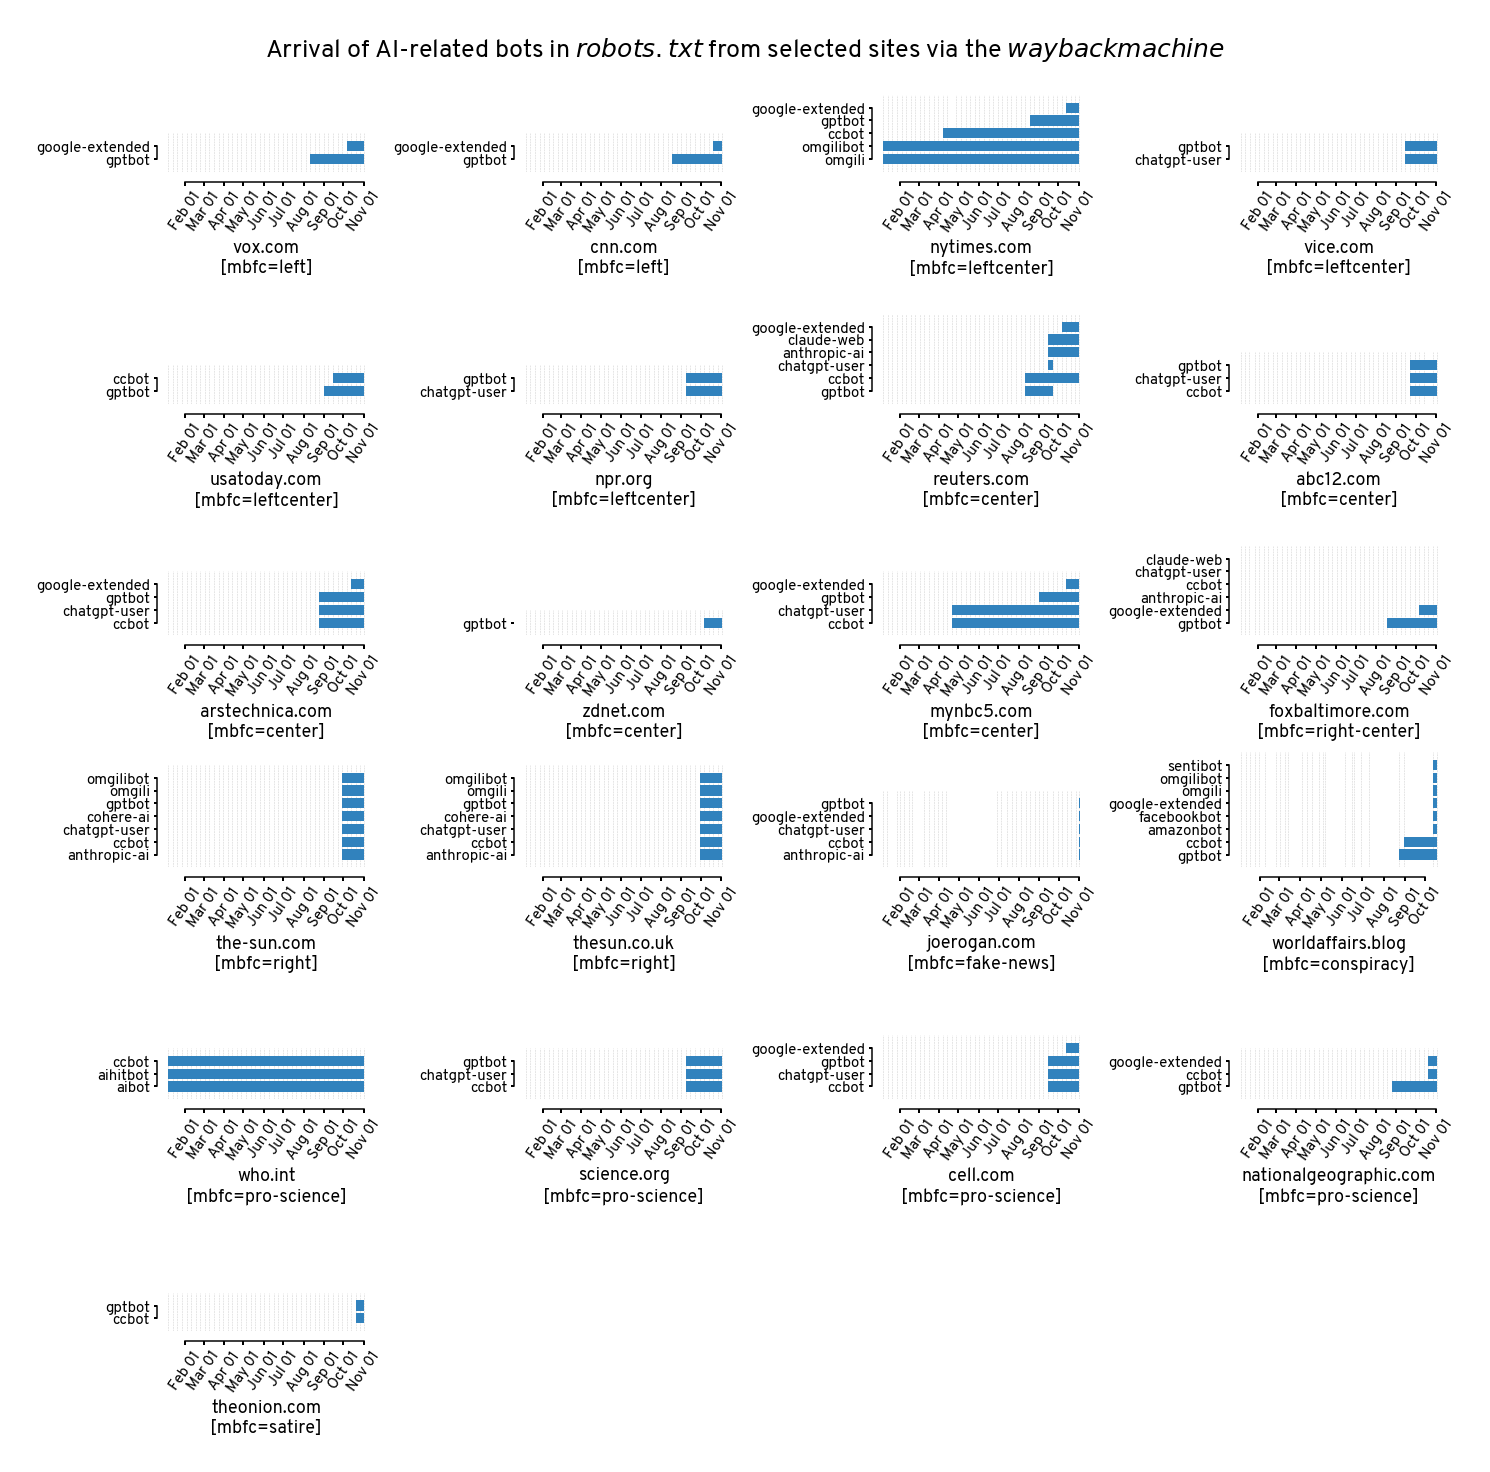

In [21]:
nrows = 6

plt.figure(figsize=(20,20))
wb_sites = df_wb['site'].unique()
ncols = int(np.ceil(len(wb_sites) / nrows))

max_bots = (
    df_wb
    .dropna(subset='bot_tag')
    .groupby('site')
    ['user_agent']
    .agg(lambda x: len(set(x)))
    .max()
)

for i, site in enumerate(wb_sites):
    ax = plt.subplot(nrows, ncols, i + 1)
    plot_bot_ranges(df_wb, site=site, ax=ax)
    ax.set_ylim([-1, max_bots])
    ax.tick_params(axis='x', rotation=55)
    
    
sns.despine(trim=True, offset=10)
plt.suptitle('Arrival of AI-related bots in $robots.txt$ from selected sites via the $wayback machine$', fontsize=25)
plt.tight_layout()

plt.savefig('figures/wayback/summary-gant.svg')
plt.savefig('figures/wayback/summary-gant.png')
